In [153]:
import pandas as pd
import json
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import re
import concurrent.futures
from tqdm import tqdm
import numpy as np

In [227]:
keyTestTPath = 'data/key_test_t.csv'
df = pd.read_csv(keyTestTPath)
# df = df[:1000]

In [228]:
def validate_json(json_str):
    try:
        json.loads(json_str)
        return True
    except:
        return False

def process_row(row):
    if validate_json(row.dimension) and validate_json(row.results):
        return row
    else:
        return None

def judgeJson(keyTestT):
    # 使用并行处理加速处理过程
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_row, keyTestT.itertuples()), total=len(keyTestT)))

    # 过滤掉返回 None 的结果并重置索引
    keyTestT = pd.DataFrame([r for r in results if r is not None])
    keyTestT = keyTestT.reset_index(drop=True)
    return keyTestT


try:
    df = pd.read_csv('data/filterFile.csv', index_col=None)
    print('filterFile.csv exists')
except FileNotFoundError:
    df = df[['results', 'dimension','results_key']]
    df = judgeJson(df)
    df.to_csv('data/filterFile.csv', index=False)
    print('filterFile.csv created')

filterFile.csv exists


In [229]:
filterFilePath = 'data/filterFile.csv'
df = pd.read_csv(filterFilePath)

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641861 entries, 0 to 641860
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Index        641861 non-null  int64 
 1   results      641861 non-null  object
 2   dimension    641861 non-null  object
 3   results_key  641861 non-null  object
dtypes: int64(1), object(3)
memory usage: 19.6+ MB


In [231]:
df.head()

,Index,results,dimension,results_key
0,0,"{""#wrk_qps_avg"": 1547599.39, ""wrk_latency_avg""...","{""cvm_cpu"": ""62"", ""platform"": ""qcloud"", ""test_...",test_1kb
1,1,"{""openssl_des_size_16"": 27246690.0, ""openssl_d...","{""cvm_cpu"": ""32"", ""platform"": ""qcloud"", ""test_...",default
2,2,"{""#ls_time"": 18}","{""dd"": ""name_11"", ""cvm_cpu"": ""1"", ""platform"": ...",default
3,3,"{""#ls_time"": 18}","{""dd"": ""name_11"", ""cvm_cpu"": ""1"", ""platform"": ...",default
4,4,"{""#mlc_idle_latency"": 90.6}","{""cvm_cpu"": ""8"", ""platform"": ""default"", ""test_...",specific_actions=idle_latency


In [232]:
# 提取 results 列中带有 "#" 号的字段
pattern = r'#\w+'  
results = df['results'].str.cat(sep=' ')  # 将所有 results 列的数据合并为一个字符串
hashtags = set(re.findall(pattern, results))  # 使用正则表达式提取带 "#" 号的字段，并去重

# 统计每个带 "#" 号的字段在整个文件中出现的次数
hashtags_dict = {}
for hashtag in hashtags:
    count = results.count(hashtag)
    hashtags_dict[hashtag] = count

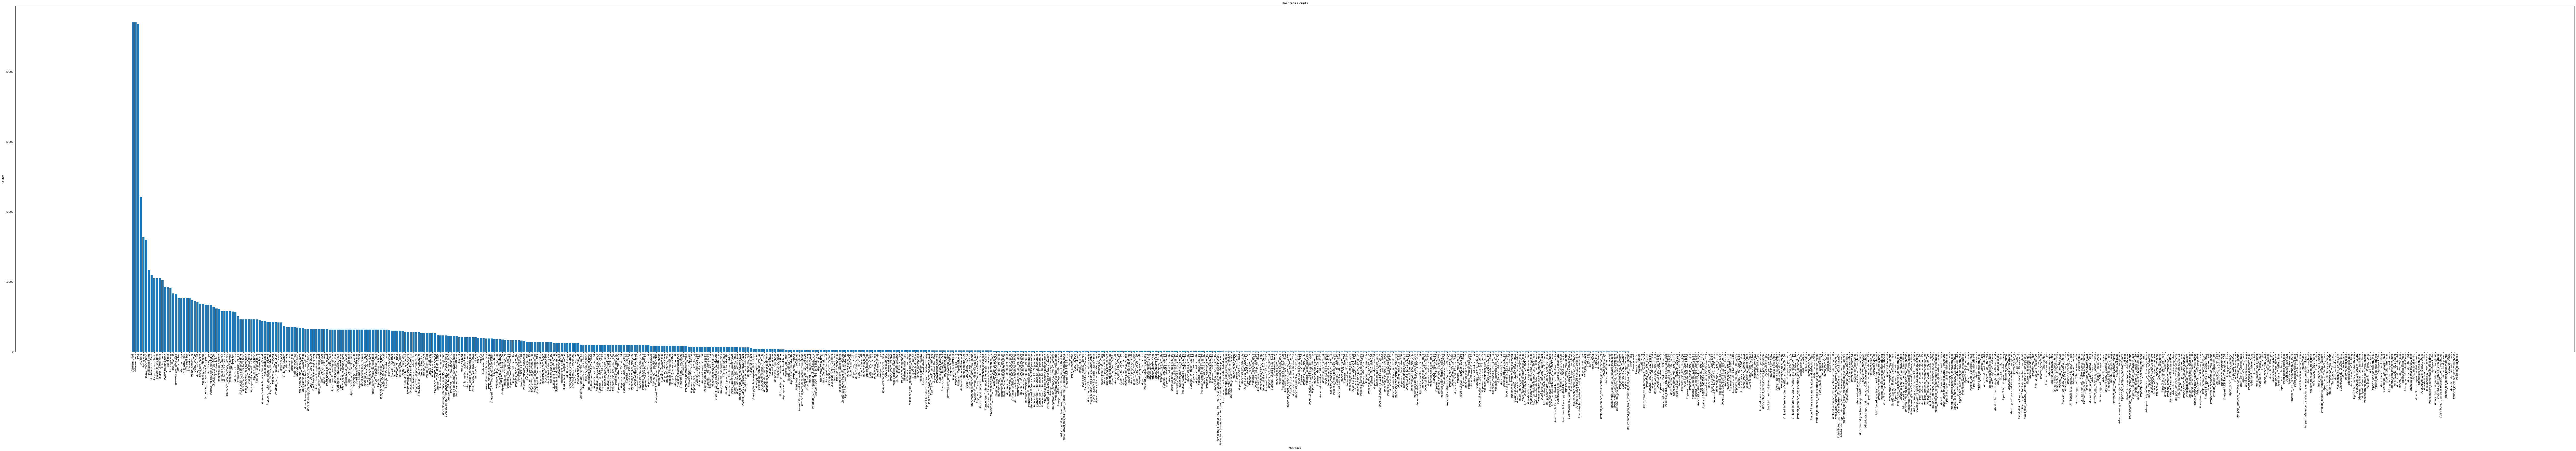

In [233]:
# 将字典按值从大到小排序
hashtags_dict_sorted = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)

# 提取排序后的键和值
hashtags_sorted = [item[0] for item in hashtags_dict_sorted]
counts_sorted = [item[1] for item in hashtags_dict_sorted]

# 绘制柱状图
plt.figure(figsize=(180, 25))  # 设置画布大小
plt.bar(hashtags_sorted, counts_sorted)  # 绘制柱状图
plt.xticks(rotation=90)  # 旋转 x 轴标签
plt.xlabel('Hashtags')  # 设置 x 轴标签
plt.ylabel('Counts')  # 设置 y 轴标签
plt.title('Hashtags Counts')  # 设置标题
plt.show()  # 显示柱状图

In [271]:
# 获取字典中数量前十的字段
top_n = 10  # 自定义获取前几个字段
top_n_fields = heapq.nlargest(top_n, hashtags_dict, key=hashtags_dict.get)

# 输出结果
print("数量前十的字段：")
for field in top_n_fields:
    print("字段名: {:<20s} 出现次数: {:d}".format(field, hashtags_dict[field]))

数量前十的字段：
字段名: #stream_triad        出现次数: 94146
字段名: #stream_copy         出现次数: 94146
字段名: #fio                 出现次数: 93701
字段名: #ls_time             出现次数: 44230
字段名: #ping_avg            出现次数: 32848
字段名: #vray_render_time    出现次数: 32004
字段名: #unixbench_cpu       出现次数: 23444
字段名: #unixbench_context   出现次数: 21977
字段名: #super_pi_user_time  出现次数: 21005
字段名: #super_pi_sys_time   出现次数: 21005


In [272]:
def getValue1(field = '#super_pi_user_time'):
    result_dict_values = {}
    result_dict_values[field] = []
    for row in df.itertuples():
        if field in row.results:
            try:
                result = eval(row.results)[field]
                result_dict_values[field].append(result)
            except:
                pass
    return result_dict_values

def getValue2(field = '#super_pi_user_time'):
    result_dict_values = {field: df.loc[df['results'].str.contains(field), 'results'].str.extract(r'\"{}\":\s*(\d+)'.format(field), expand=False).dropna().astype(float).tolist()}
    return result_dict_values

In [299]:
result_dict_values = getValue1('#vray_render_time')

In [300]:
# 将result_dict转换为DataFrame
outPutDF = pd.DataFrame(result_dict_values)

In [301]:
outPutDF.head()

,#vray_render_time
0,21
1,105
2,106
3,78
4,152


In [302]:
# def getInput(keyTestT, importantKey):
#     inputList = []
#     keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
#     dimension_dict = {'cvm_cpu': None, 'cvm_memory': None, 'cvm_cpu_qos': None, 'cvm_os_type': None}
#     for i in tqdm(range(len(keyTestT))):
#         results = json.loads(keyTestT.loc[i, 'results'])
#         for result in results:
#             if importantKey in result:
#                 # 将dimension中['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']这几个字段的值提取出来
#                 if not dimension_dict['cvm_cpu']:
#                     dimension = json.loads(keyTestT.loc[i, 'dimension'])
#                     dimension_dict.update(dimension)
#                 templist = [dimension_dict[key] for key in keys_to_extract]
#                 results_key = keyTestT.loc[i, 'results_key']
#                 templist.append(results_key)
#                 inputList.append(templist)
#                 break
#     return inputList

def getInput(keyTestT, importantKey):
    inputList = []
    keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
    for i in tqdm(range(len(keyTestT))):
        results = json.loads(keyTestT.loc[i, 'results'])
        for result in results:
            if importantKey in result:
                # 将dimension中['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']这几个字段的值提取出来
                dimension = json.loads(keyTestT.loc[i, 'dimension'])
                dimension = json.dumps(dimension)
                templist=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
                dimensionJson = json.loads(dimension)
                for key in dimensionJson:
                    if key in templist:
                        key_value = dimensionJson[key]
                        if key=='cvm_memory':
                            key_value=float(key_value.split(' ')[0])
                        elif key=='cvm_cpu':
                            key_value=float(key_value)
                        elif key=='cvm_cpu_qos':
                            key_value='true'
                        templist[keys_to_extract.index(key)]=key_value
                results_key = keyTestT.loc[i, 'results_key']
                templist.append(results_key)
                inputList.append(templist)
                break
    return inputList

In [303]:
inputList = getInput(df, '#vray_render_time')

100%|██████████| 641861/641861 [00:15<00:00, 40423.59it/s]


In [304]:
# 将inputList转换为DataFrame
inputDF = pd.DataFrame(inputList, columns=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'results_key'])

In [305]:
inputDF.head()

,cvm_cpu,cvm_memory,cvm_cpu_qos,cvm_os_type,results_key
0,90,226,cvm_cpu_qos,CentOS Linux release 7.4.1708 (Core),mode=cpu
1,8,16,cvm_cpu_qos,Tencent tlinux release 2.2 (tkernel3),mode=cpu
2,8,16,cvm_cpu_qos,Tencent tlinux release 2.2 (tkernel3),mode=cpu
3,16,64,true,CentOS Linux release 8.2.2004 (Core),mode=cpu
4,8,32,true,CentOS Linux release 8.2.2004 (Core),mode=cpu


In [306]:
# 判断cvm_cpu和cvm_memory是否是数字，如果不是数字则填写-1
inputDF['cvm_cpu'] = pd.to_numeric(inputDF['cvm_cpu'], errors='coerce').fillna(-1)
inputDF['cvm_memory'] = pd.to_numeric(inputDF['cvm_memory'], errors='coerce').fillna(-1)

In [307]:
print(inputDF.shape)
print(outPutDF.shape)

(32004, 5)
(32004, 1)


In [308]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [312]:
def showPic(methodName, y_test, y_pred):
    # 创建柱状图
    plt.figure(figsize=(80, 15))

    # plt.subplot(1, 2, 1)
    # plt.scatter(y_test, y_pred)
    # plt.xlabel('True Values')
    # plt.ylabel('Predicted Values')
    # plt.title('{}: True Values vs. Predicted Values'.format(methodName))

    plt.subplot(1, 2, 1)
    # 创建样本索引数组
    index = np.arange(len(y_test))
    # 绘制线性回归模型的折线图
    plt.plot(index, y_test, label='True Values')
    plt.plot(index, y_pred, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))
    plt.legend()

    plt.show()



def train(X, y):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 初始化模型
    linear_reg = LinearRegression()
    decision_tree_reg = DecisionTreeRegressor()
    random_forest_reg = RandomForestRegressor(n_estimators=1000, max_depth=5)
    svm_reg = SVR(C=1.0, epsilon=0.1)
    knn_reg = KNeighborsRegressor(n_neighbors=10, weights='uniform')


    # 拟合模型
    linear_reg.fit(X_train, y_train)
    decision_tree_reg.fit(X_train, y_train)
    random_forest_reg.fit(X_train, y_train)
    svm_reg.fit(X_train, y_train)
    knn_reg.fit(X_train, y_train)


    # 预测
    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)


    # 计算评估指标
    mse_linear_reg = mean_squared_error(y_test, y_pred_linear_reg)
    mse_decision_tree_reg = mean_squared_error(y_test, y_pred_decision_tree_reg)
    mse_random_forest_reg = mean_squared_error(y_test, y_pred_random_forest_reg)
    mse_svm_reg = mean_squared_error(y_test, y_pred_svm_reg)
    mse_knn_reg = mean_squared_error(y_test, y_pred_knn_reg)

    mae_linear_reg = mean_absolute_error(y_test, y_pred_linear_reg)
    mae_decision_tree_reg = mean_absolute_error(y_test, y_pred_decision_tree_reg)
    mae_random_forest_reg = mean_absolute_error(y_test, y_pred_random_forest_reg)
    mae_svm_reg = mean_absolute_error(y_test, y_pred_svm_reg)
    mae_knn_reg = mean_absolute_error(y_test, y_pred_knn_reg)

    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)


    # 打印评估指标
    # print('Linear Regression MSE:', mse_linear_reg)
    # print('Decision Tree Regression MSE:', mse_decision_tree_reg)
    # print('Random Forest Regression MSE:', mse_random_forest_reg)
    # print('Support Vector Regression MSE:', mse_svm_reg)
    # print('KNN Regression MSE:', mse_knn_reg)
    # print('\n')
    # print('Linear Regression MAE:', mae_linear_reg)
    # print('Decision Tree Regression MAE:', mae_decision_tree_reg)
    # print('Random Forest Regression MAE:', mae_random_forest_reg)
    # print('Support Vector Regression MAE:', mae_svm_reg)
    # print('KNN Regression MAE:', mae_knn_reg)
    # print('\n')
    print('Linear Regression R2:', r2_linear_reg)
    print('Decision Tree Regression R2:', r2_decision_tree_reg)
    print('Random Forest Regression R2:', r2_random_forest_reg)
    print('Support Vector Regression R2:', r2_svm_reg)
    print('KNN Regression R2:', r2_knn_reg)
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = ['y_pred_linear_reg', 'y_pred_decision_tree_reg', 'y_pred_random_forest_reg', 'y_pred_svm_reg', 'y_pred_knn_reg']
    for i in range(len(models)):
        showPic(models[i], y_test, eval(y_pred[i]))


In [313]:
inputDF['cvm_cpu'] = pd.to_numeric(inputDF['cvm_cpu'])
inputDF['cvm_memory'] = pd.to_numeric(inputDF['cvm_memory'])
one_hot_df = pd.get_dummies(inputDF, columns=['cvm_cpu_qos', 'cvm_os_type','results_key'])
X = one_hot_df
y = outPutDF

e:\test\envs\pytorch\lib\site-packages\ipykernel_launcher.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
e:\test\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Linear Regression R2: 0.25004934399498024
Decision Tree Regression R2: 0.8101645544665654
Random Forest Regression R2: 0.8154952055804915
Support Vector Regression R2: 0.14373448427282476
KNN Regression R2: 0.8042335219387257




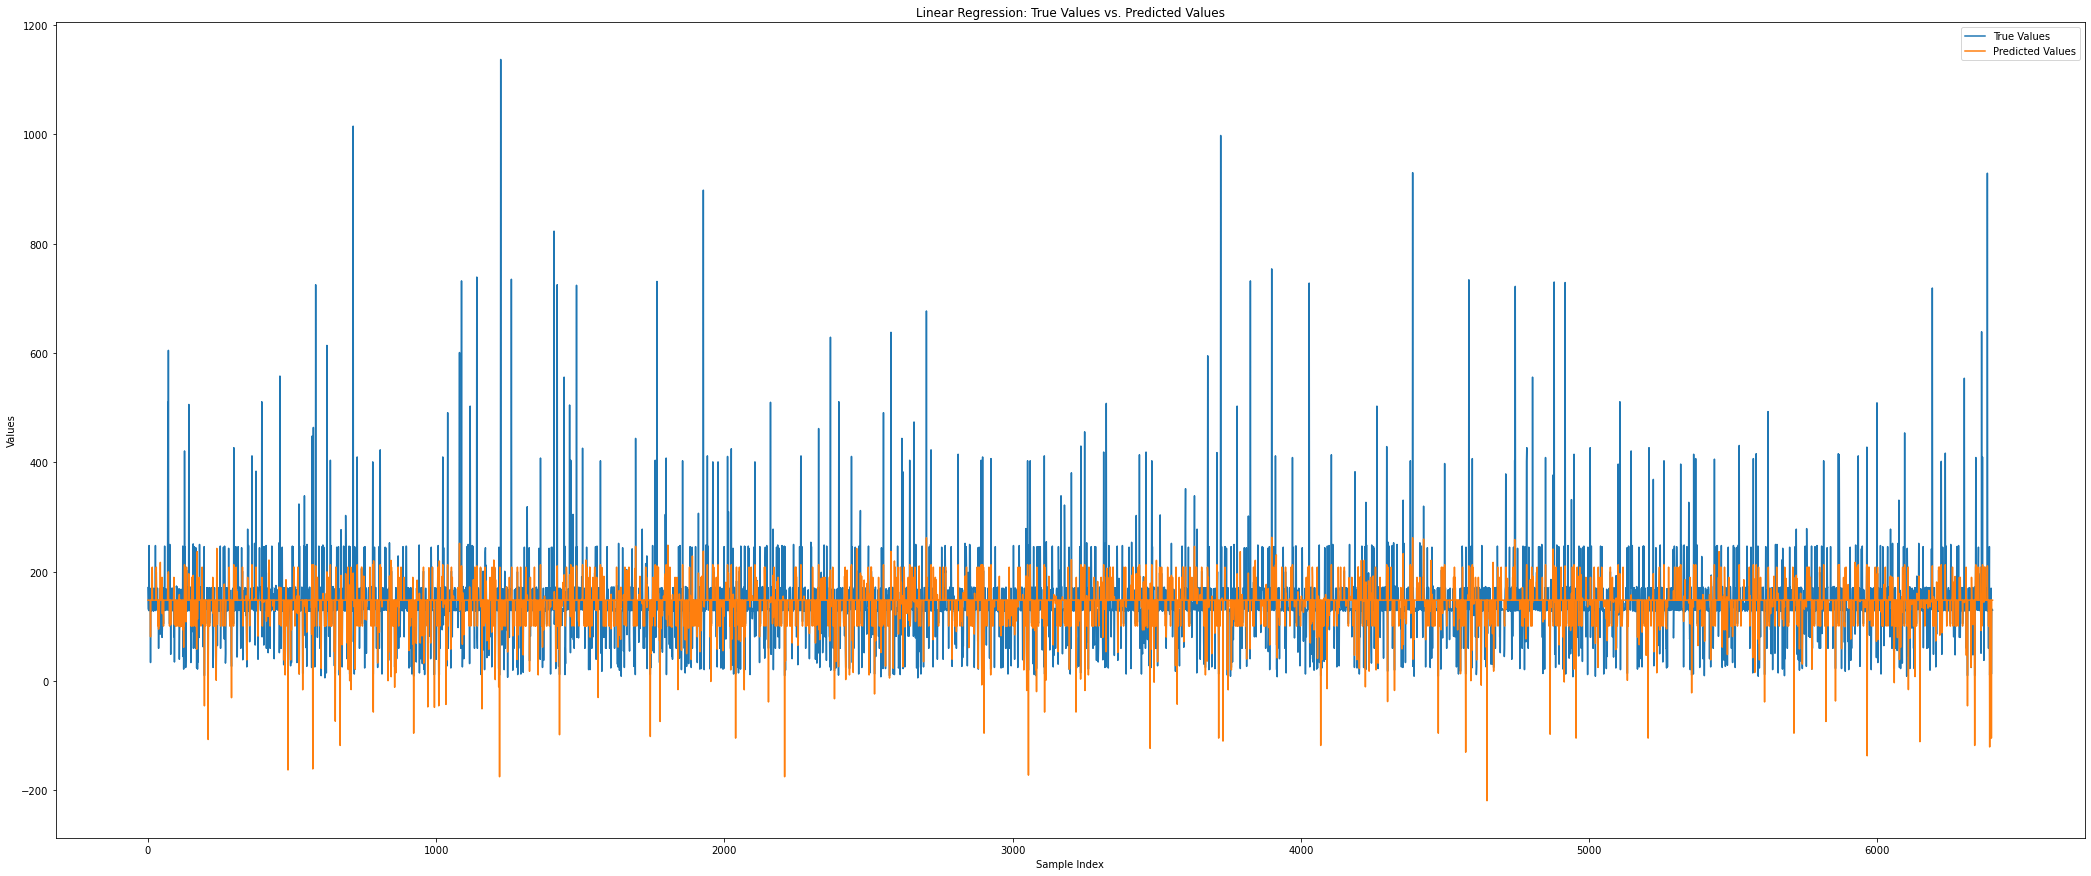

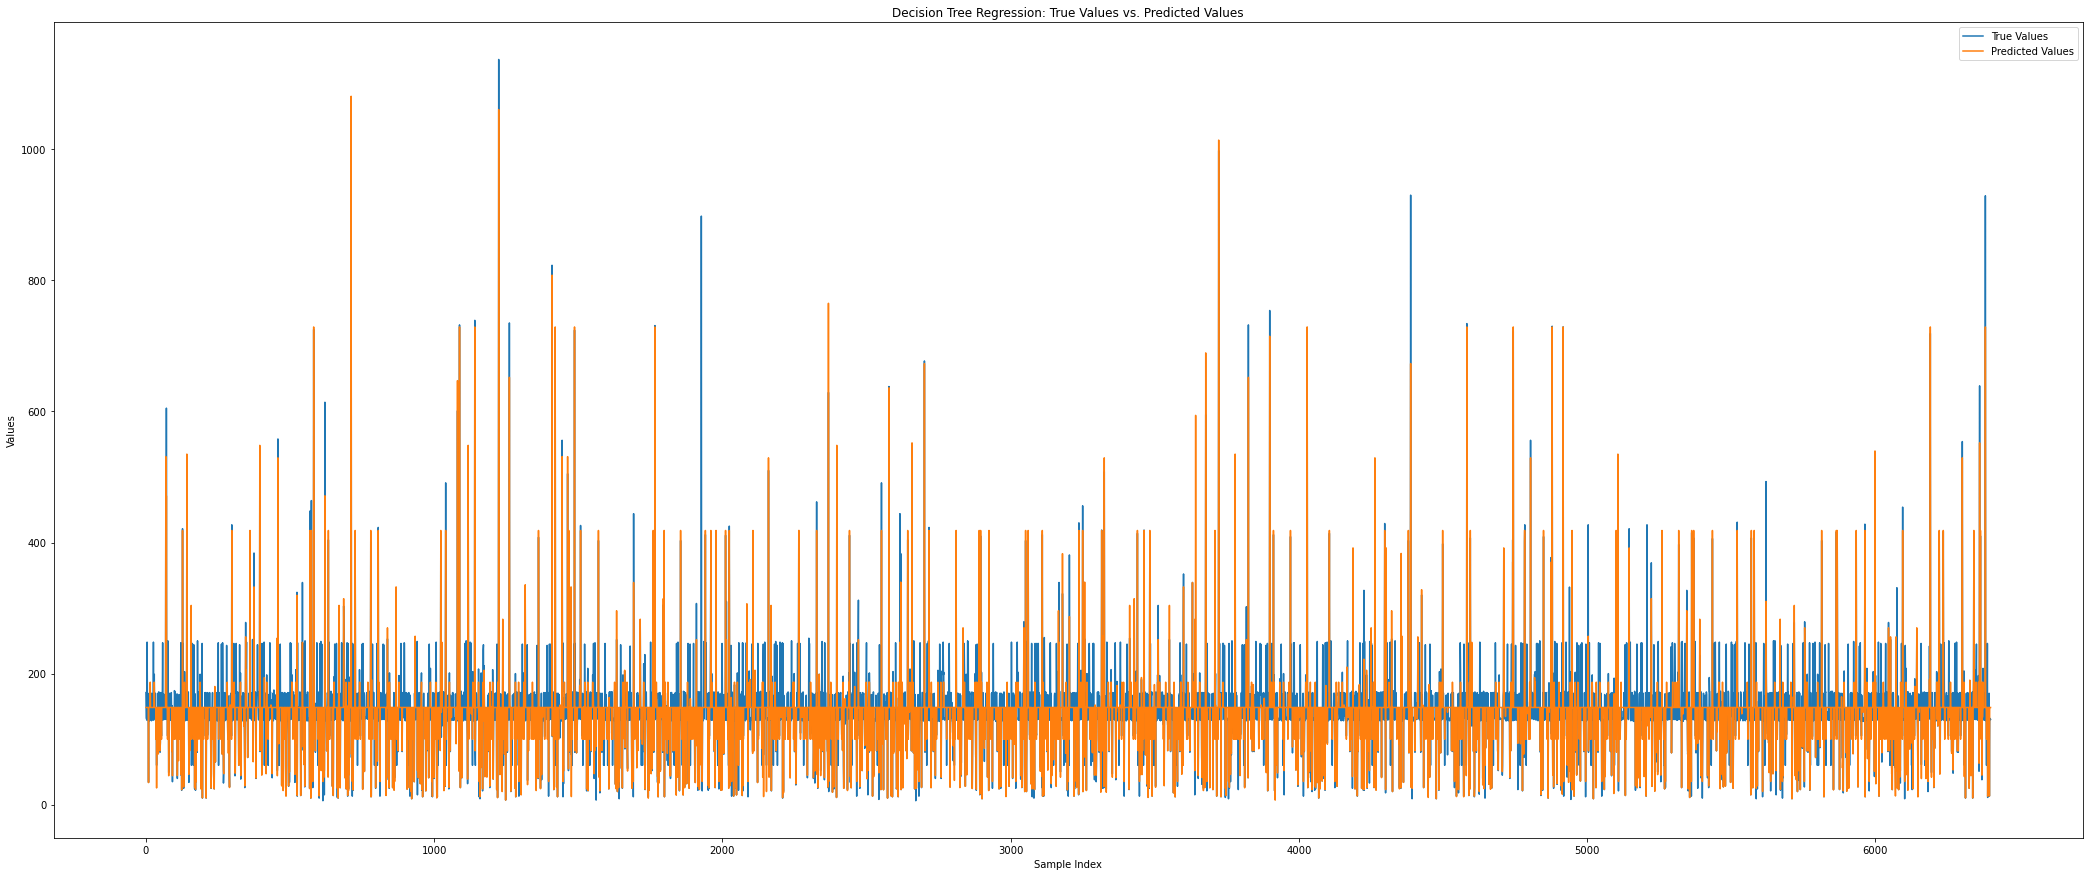

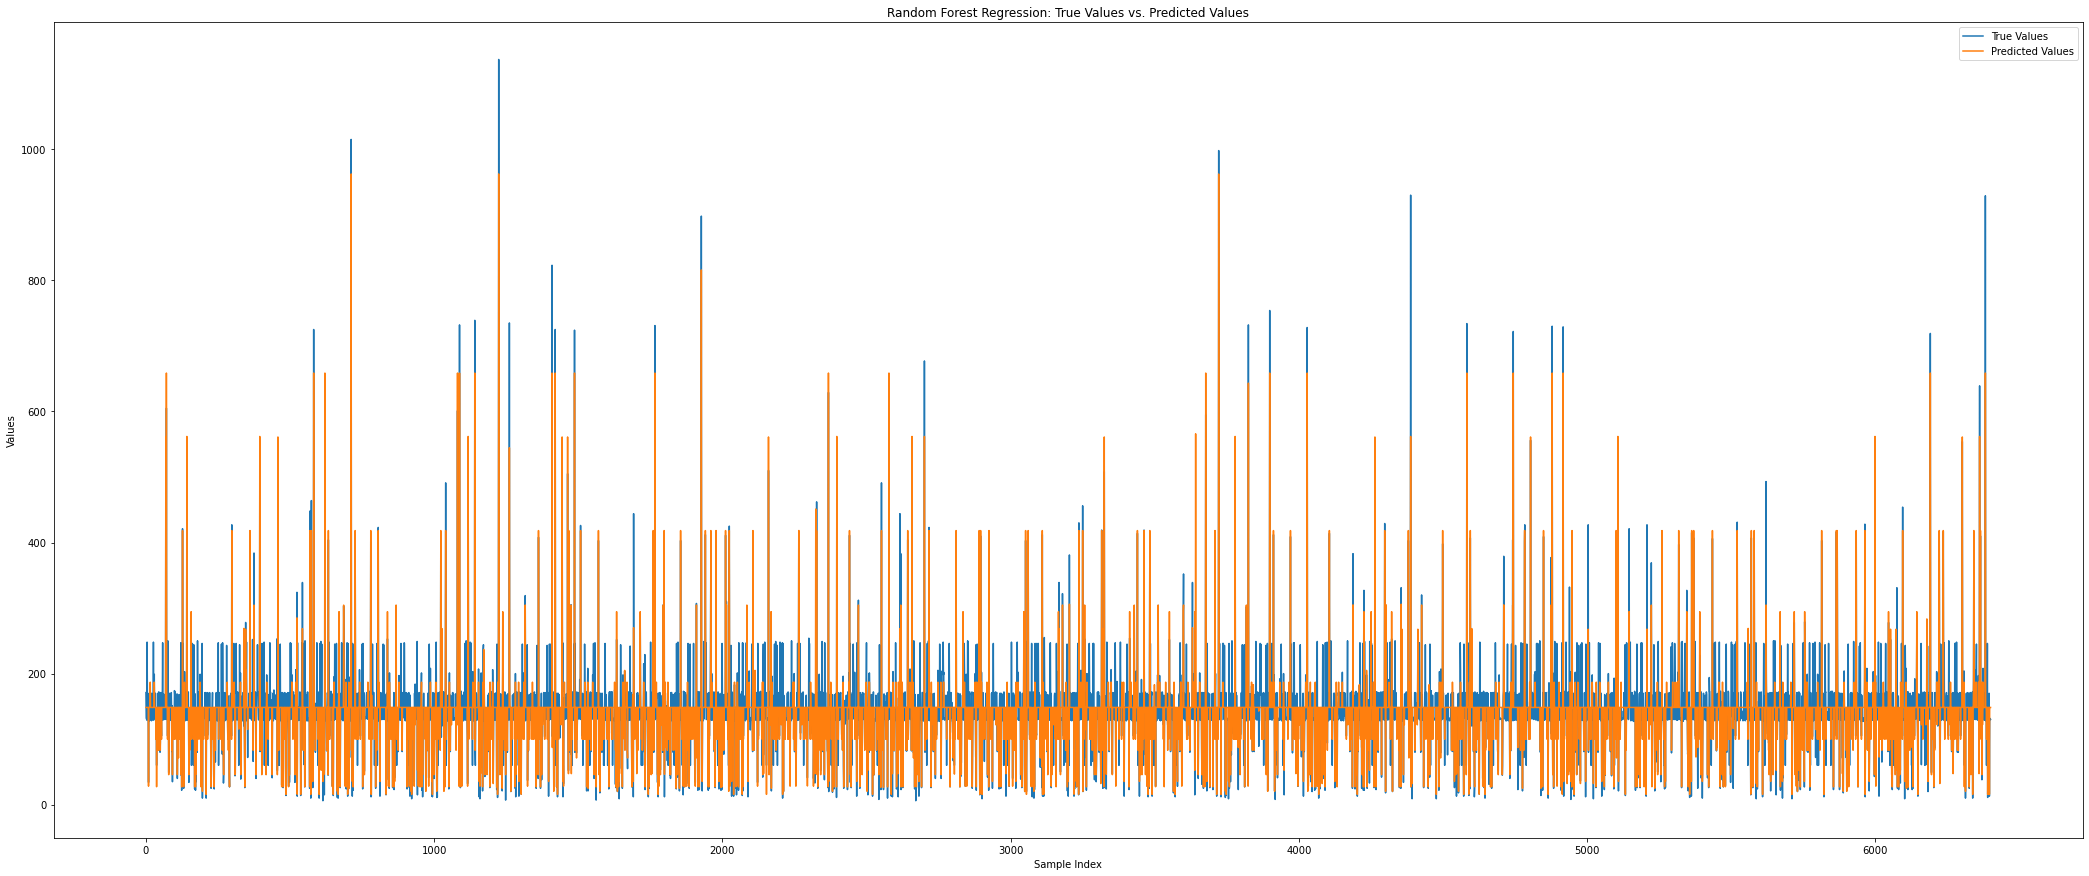

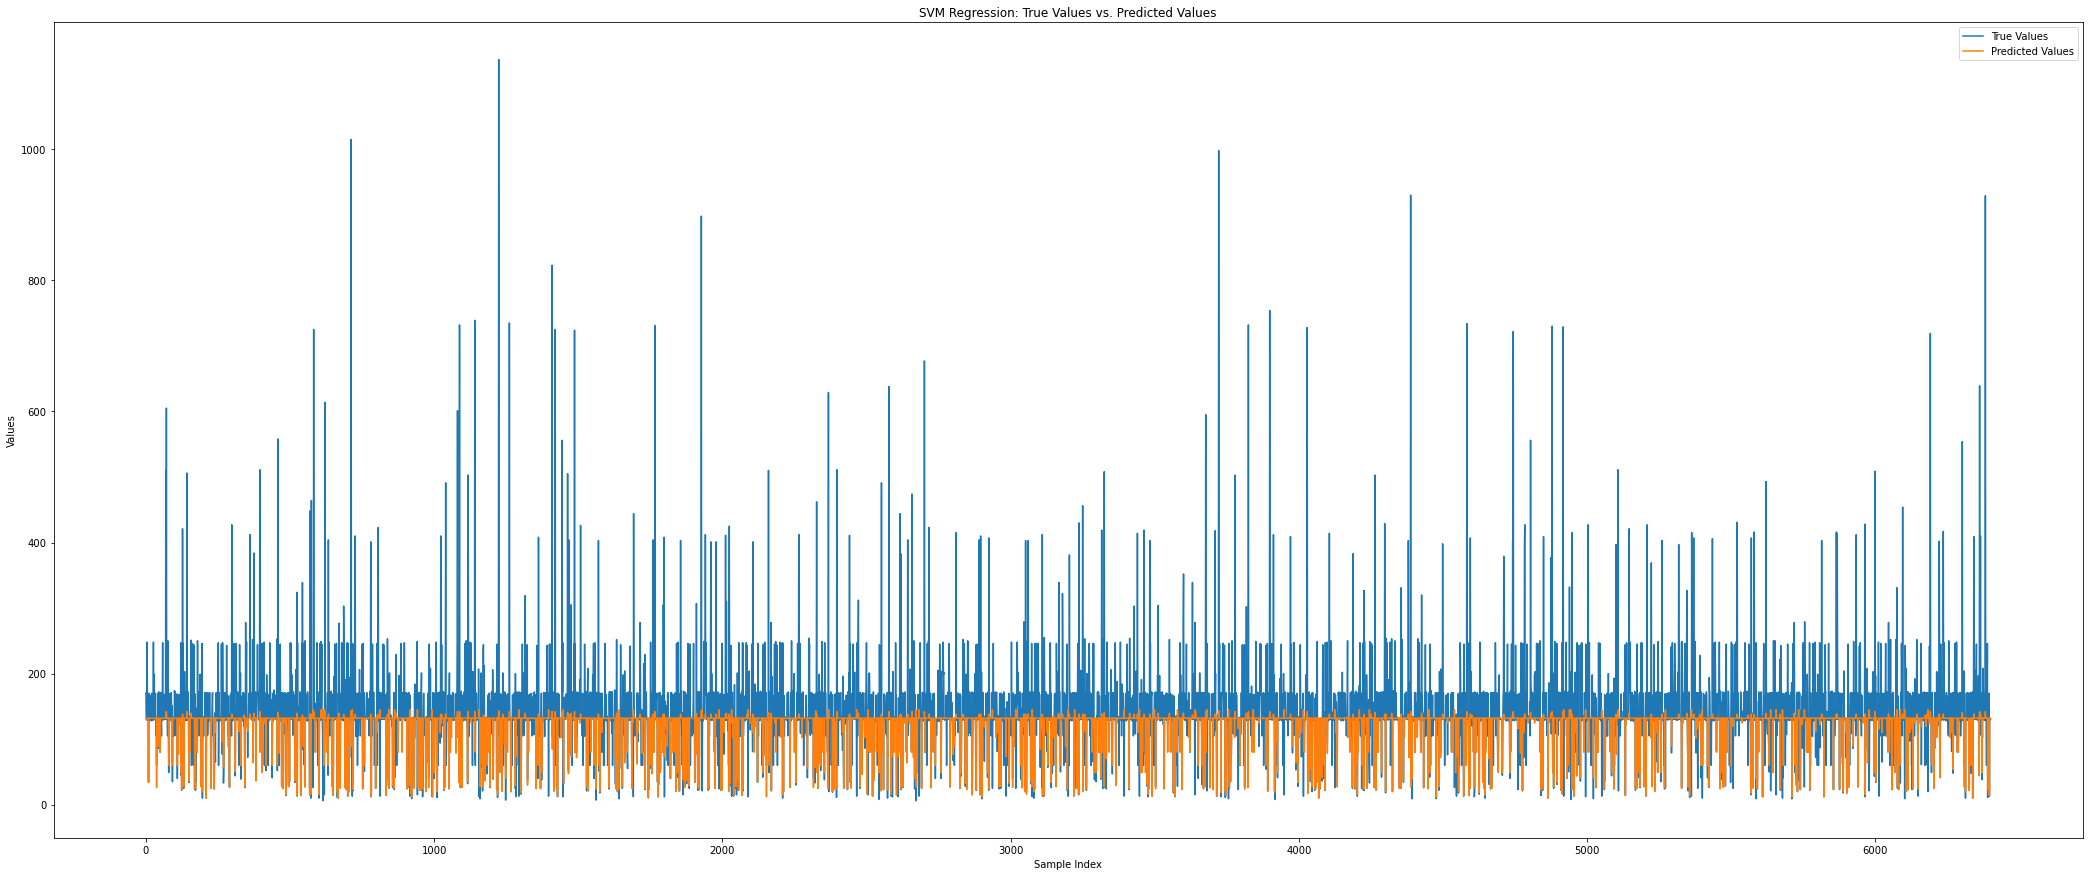

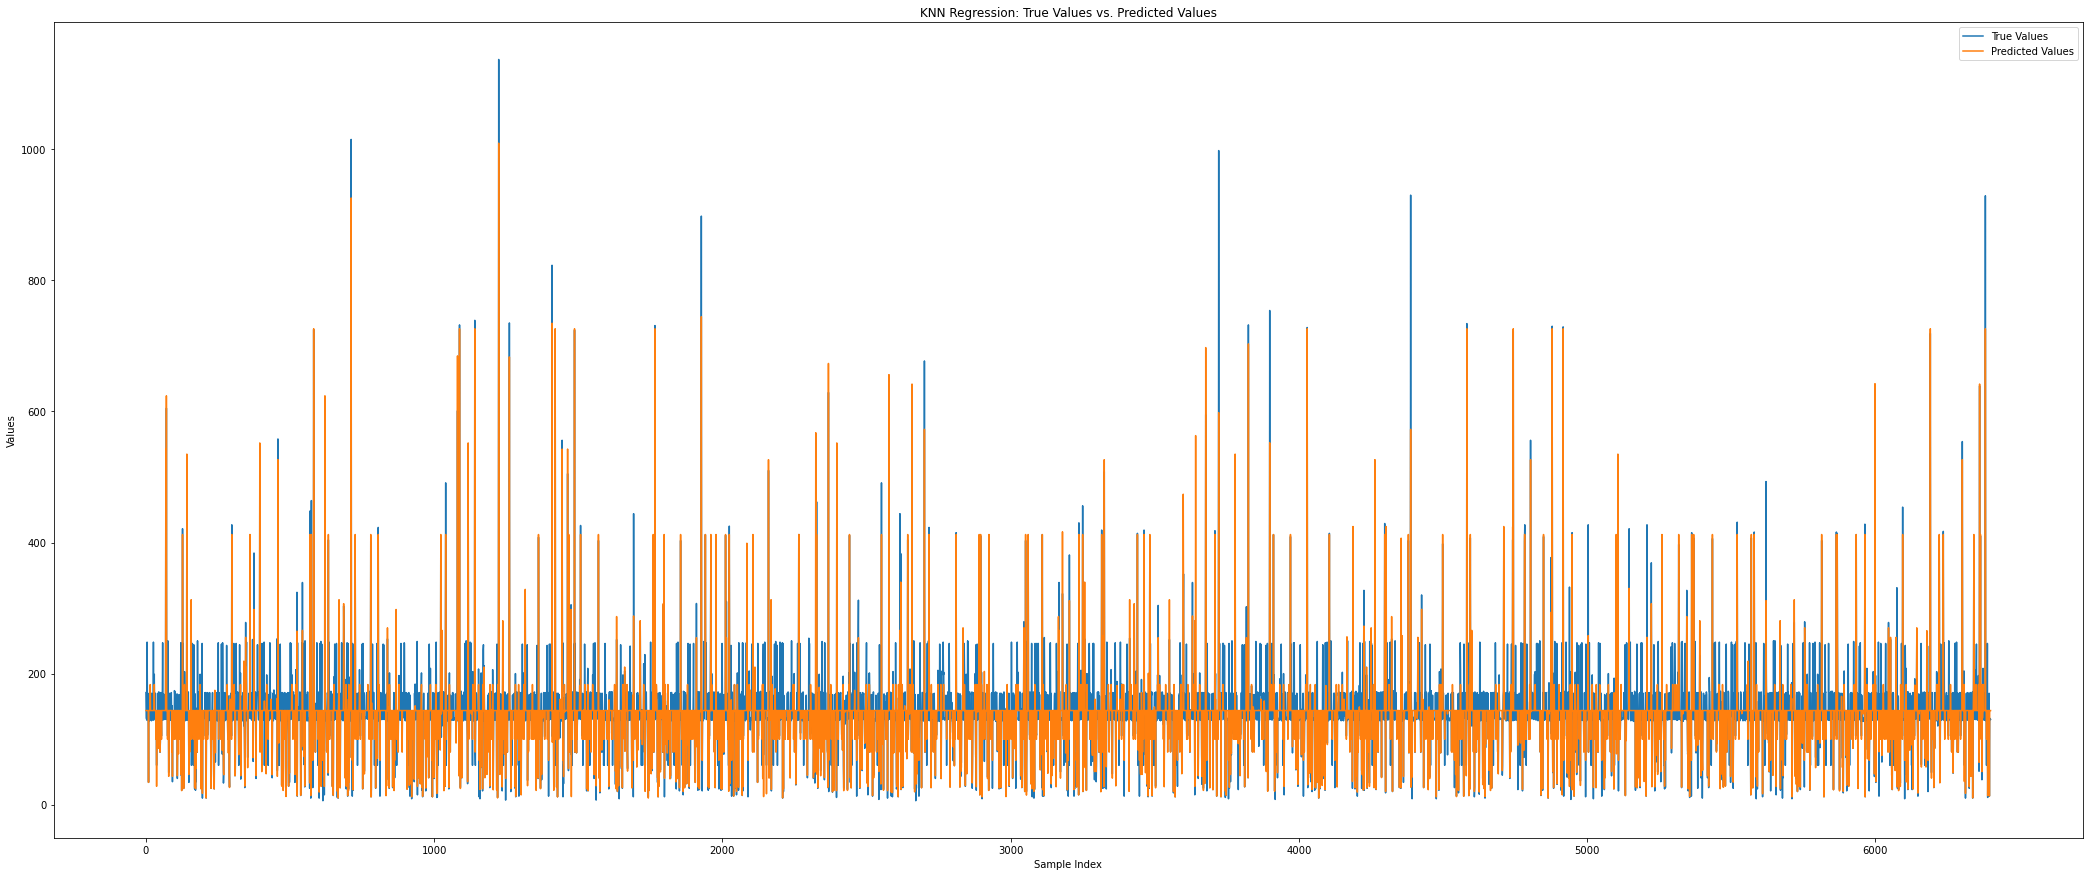

In [314]:
train(X, y)